In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import sys
if '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings' not in sys.path:
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings')

from seq2tensor import s2t
import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, LSTM, Bidirectional, BatchNormalization, add
from keras.layers.core import Flatten, Reshape
from keras.layers import Concatenate, concatenate, subtract, multiply
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D

from keras.optimizers import Adam,  RMSprop

import os
import tensorflow as tf
import numpy as np
from tqdm import tqdm

from keras.layers import Input, CuDNNGRU
from numpy import linalg as LA
import scipy

In [9]:
# Note: if you use another PPI dataset, this needs to be changed to a corresponding dictionary file.
id2seq_file = '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/yeast/preprocessed/protein.dictionary.tsv'

id2index = {}
seqs = []
index = 0
for line in open(id2seq_file):
    line = line.strip().split('\t')
    id2index[line[0]] = index
    seqs.append(line[1])
    index += 1
seq_array = []
id2_aid = {}
sid = 0

In [2]:
seq_size = 2000
emb_files = ['/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/physio.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/string_vec5.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/CTCoding_onehot.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/vec7_CTC.txt']
use_emb = 3
hidden_dim = 50
n_epochs=100

In [3]:
# ds_file, label_index, rst_file, use_emb, hidden_dim
ds_file = '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/yeast/preprocessed/protein.actions.tsv'
label_index = 2
rst_file = 'results/15k_onehot_cnn.txt'
sid1_index = 0
sid2_index = 1
#if len(sys.argv) > 1:
#    ds_file, label_index, rst_file, use_emb, hidden_dim, n_epochs = sys.argv[1:]
#    label_index = int(label_index)
#    use_emb = int(use_emb)
#    hidden_dim = int(hidden_dim)
#    n_epochs = int(n_epochs)

In [4]:
seq2t = s2t(emb_files[use_emb])

In [5]:
max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = True
x = None
count = 0

In [10]:
for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break
print (len(raw_data))

11188it [00:00, 378501.61it/s]

11188


In [11]:
len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
print (avg_m_seq, max_m_seq)

2 1


In [13]:
dim = seq2t.dim
seq_tensor = np.array([seq2t.embed_normalized(line, seq_size) for line in tqdm(seq_array)])
seq_index1 = np.array([line[sid1_index] for line in tqdm(raw_data)])
seq_index2 = np.array([line[sid2_index] for line in tqdm(raw_data)])
print(seq_index1[:10])
print(dim)

100%|██████████| 11188/11188 [00:00<00:00, 1945355.82it/s]

[ 0  2  4  6  8 10 12 12 15 17]
15


In [14]:
class_map = {'0':1,'1':0}
print(class_map)
class_labels = np.zeros((len(raw_data), 2))
for i in range(len(raw_data)):
    class_labels[i][class_map[raw_data[i][label_index]]] = 1.


{'0': 1, '1': 0}


In [15]:
#WAVELET CODE
#emb_files = ['/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/physio.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/string_vec5.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/CTCoding_onehot.txt', '/content/drive/MyDrive/Colab Notebooks/seq_ppi-master/embeddings/vec7_CTC.txt']
use_emb = 0
seq2t_W = s2t(emb_files[use_emb])

max_data = -1
limit_data = max_data > 0
raw_data = []
skip_head = True
x = None
count = 0

for line in tqdm(open(ds_file)):
    if skip_head:
        skip_head = False
        continue
    line = line.rstrip('\n').rstrip('\r').split('\t')
    if id2index.get(line[sid1_index]) is None or id2index.get(line[sid2_index]) is None:
        continue
    if id2_aid.get(line[sid1_index]) is None:
        id2_aid[line[sid1_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid1_index]]])
    line[sid1_index] = id2_aid[line[sid1_index]]
    if id2_aid.get(line[sid2_index]) is None:
        id2_aid[line[sid2_index]] = sid
        sid += 1
        seq_array.append(seqs[id2index[line[sid2_index]]])
    line[sid2_index] = id2_aid[line[sid2_index]]
    raw_data.append(line)
    if limit_data:
        count += 1
        if count >= max_data:
            break
print (len(raw_data))

len_m_seq = np.array([len(line.split()) for line in seq_array])
avg_m_seq = int(np.average(len_m_seq)) + 1
max_m_seq = max(len_m_seq)
print (avg_m_seq, max_m_seq)
# dim = seq2t_W.dim
seq_tensor_W = np.array([seq2t_W.embed_normalized(line, seq_size) for line in tqdm(seq_array)])


11188it [00:00, 398965.07it/s]


11187
2 1


100%|██████████| 2497/2497 [00:00<00:00, 3756.19it/s]


In [16]:
#Wavelet feature generation
import pywt
import pywt.data
import scipy.special as special
from scipy.stats import entropy
from scipy.stats import linregress
from collections import Counter
from scipy.stats import kurtosis
from scipy.stats import moment
import pandas

# local variaable definition
# twoD_feature_of_Amino_acides_before_wavelet_transform = []  # Vectore for append all the wavelet produced matrixes
# coeffs = []

# counter = 0
# #T.W=[]

# T_W = np.zeros((seq_tensor_W.shape[0],35))

# #using different filterbanks name
# #for filter in ['db2','db3' ,'db4','db5','db6','db7','db8','db9','bior1.3','bior1.5','bior2.2','bior2.4','bior2.6','bior3.1','bior3.3','bior3.5','bior3.7','bior4.4','bior5.5','coif1','coif2','coif3','coif4','coif5','sym2','sym3','sym4','sym5','sym6','sym7','sym8']:
# print("Generating Features For ",'db2', " Filter bank started")

In [ ]:
#wavelet first layer
#15 filters

coeffs = []

counter = -1

T_W = np.zeros((seq_tensor_W.shape[0],35,15))
for filter in ['db2','db3' ,'db4','db5','bior1.3','bior1.5','bior2.2','bior2.4','coif1','coif2','coif3','sym2','sym3','sym4','sym5']:
  print("Generating Features For ",filter, " Filter bank started")
  counter = counter + 1
  for i in range(seq_tensor_W.shape[0]):
            #if len(twoD_feature_of_Amino_acides_before_wavelet_transform) != 0:

                
                coeffs = pywt.dwt2(seq_tensor_W[i], filter)
                # LL, (LH, HL, HH),(LH1,HL1,HH1),(LH2, HL2, HH2),(LH3, HL3, HH3) = coeffs
                LL, (LH, HL, HH) = coeffs # separate the Approximate coefficient and detail coefficient to 4 signals

               #generating the criteria including max, min, median, average, Standard deviation,energy, entopy,
               #slope and SED error for details coeeficient towards approximate coefficient
               #overal energy and wavelength for overal signal and write in the file for each filter bank
                LLenergy = np.sqrt(np.sum(np.array(LL[-1]) ** 2)) / len(LL[-1])
                LHenergy = np.sqrt(np.sum(np.array(LH[-1]) ** 2)) / len(LH[-1])
                HLenergy = np.sqrt(np.sum(np.array(HL[-1]) ** 2)) / len(HL[-1])
                HHenergy = np.sqrt(np.sum(np.array(HH[-1]) ** 2)) / len(HH[-1])
                overalEnergy = np.sqrt(np.sum(np.array(coeffs[-1]) ** 2)) / len(coeffs[-1])
                LLwavelength = len(LL)

                LL = np.concatenate(LL)
                LH = np.concatenate(LH)
                HL = np.concatenate(HL)
                HH = np.concatenate(HH)

                LL1energy = np.sqrt(np.sum(np.array(LL[-1]) ** 2)) / len(LL)
                LH1energy = np.sqrt(np.sum(np.array(LH[-1]) ** 2)) / len(LH)
                HL1energy = np.sqrt(np.sum(np.array(HL[-1]) ** 2)) / len(HL)
                HH1energy = np.sqrt(np.sum(np.array(HH[-1]) ** 2)) / len(HH)

                LHslope, LHintercept, LHr_value, LHp_value, LHstd_err = linregress(LL, LH)
                HLslope, HLintercept, HLr_value, HLp_value, HLstd_err = linregress(LL, HL)
                HHslope, HHintercept, HHr_value, HHp_value, HHstd_err = linregress(LL, HH)

                maxLL = np.max(LL)
                minLL = np.min(LL)
                AvLL = np.average(LL)
                MedianLL = (minLL + maxLL) / 2

                pd_series = pandas.Series(LL)
                counts = pd_series.value_counts()
                LLentropy = entropy(counts)

                maxLH = np.max(LH)
                minLH = np.min(LH)
                AvLH = np.average(LH)
                MedianLH = (minLH + maxLH) / 2

                pd_series = pandas.Series(LH)
                counts = pd_series.value_counts()
                LHentropy = entropy(counts)

                maxHL = np.max(HL)
                minHL = np.min(HL)
                AvHL = np.average(HL)
                MedianHL = (minHL + maxHL) / 2

                pd_series = pandas.Series(HL)
                counts = pd_series.value_counts()
                HLentropy = entropy(counts)

                maxHH = np.max(HH)
                minHH = np.min(HH)
                AvHH = np.average(HH)
                MedianHH = (minHH + maxHH) / 2

                pd_series = pandas.Series(HH)
                counts = pd_series.value_counts()
                HHentropy = entropy(counts)

                # f3.write(str(maxLL) + '\t' + str(maxLH) + '\t' + str(maxHL) + '\t' + str(maxHH) + '\t' + str(
                #     minLL) + '\t' + str(minLH) + '\t' + str(minHL) + '\t' + str(minHH) + '\t' + str(
                #     AvLL) + '\t' + str(AvLH) + '\t' + str(AvHL) + '\t' + str(AvHH) + '\t' + str(
                #     MedianLL) + '\t' + str(
                #     MedianLH) + '\t' + str(MedianHL) + '\t' + str(MedianHH) + '\t' + str(
                #     np.std(LL)) + '\t' + str(
                #     np.std(LH)) + '\t' + str(np.std(HL)) + '\t' + str(np.std(HH)) + '\t' + str(
                #     LLentropy) + '\t' + str(LHentropy) + '\t' + str(HLentropy) + '\t' +
                #          str(HHentropy) + '\t' + str(LLenergy) + '\t' + str(LHenergy) + '\t' + str(
                #     HLenergy) + '\t' + str(HHenergy)

                #          + '\t' + str(LHslope) + '\t' + str(HLslope) + '\t' + str(HHslope) +
                #          '\t' + str(LHstd_err) + '\t' + str(HLstd_err) + '\t' + str(HHstd_err) + '\t' + str(
                #     LLwavelength) + '\t' + str(overalEnergy) + '\n')
                
                T_W[i,:,counter] = [maxLL,maxLH,maxHL,maxHH,minLL,minLH,minHL,minHH,AvLL,AvLH,AvHL,AvHH,MedianLL,MedianHL,MedianHH,np.std(LL),np.std(LH),np.std(HL),np.std(HH),LLentropy,LHentropy,HLentropy,HHentropy,LLenergy,LHenergy,HLenergy,HHenergy,LHslope,HLslope,HHslope,LHstd_err,HLstd_err,HHstd_err,LLwavelength,overalEnergy]


print("Feature Extraction Finished")

Generating Features For  db2  Filter bank started
Generating Features For  db3  Filter bank started
Generating Features For  db4  Filter bank started
Generating Features For  db5  Filter bank started
Generating Features For  bior1.3  Filter bank started
Generating Features For  bior1.5  Filter bank started
Generating Features For  bior2.2  Filter bank started
Generating Features For  bior2.4  Filter bank started
Generating Features For  coif1  Filter bank started
Generating Features For  coif2  Filter bank started
Generating Features For  coif3  Filter bank started
Generating Features For  sym2  Filter bank started
Generating Features For  sym3  Filter bank started
Generating Features For  sym4  Filter bank started
Generating Features For  sym5  Filter bank started
Feature Extraction Finished


In [18]:
#wavelet last layer
#all filters

coeffs = []

counter = -1

T_W = np.zeros((seq_tensor_W.shape[0],35,31))
for filter in ['db2','db3' ,'db4','db5','db6','db7','db8','db9','bior1.3','bior1.5','bior2.2','bior2.4','bior2.6','bior3.1','bior3.3','bior3.5','bior3.7','bior4.4','bior5.5','coif1','coif2','coif3','coif4','coif5','sym2','sym3','sym4','sym5','sym6','sym7','sym8']:
  print("Generating Features For ",filter, " Filter bank started")
  counter = counter + 1
  for i in range(seq_tensor_W.shape[0]):
            #if len(twoD_feature_of_Amino_acides_before_wavelet_transform) != 0:

                
                coeffs = pywt.dwt2(seq_tensor_W[i], filter)
                # LL, (LH, HL, HH),(LH1,HL1,HH1),(LH2, HL2, HH2),(LH3, HL3, HH3) = coeffs
                LL, (LH, HL, HH) = coeffs # separate the Approximate coefficient and detail coefficient to 4 signals

               #generating the criteria including max, min, median, average, Standard deviation,energy, entopy,
               #slope and SED error for details coeeficient towards approximate coefficient
               #overal energy and wavelength for overal signal and write in the file for each filter bank
                LLenergy = np.sqrt(np.sum(np.array(LL[-1]) ** 2)) / len(LL[-1])
                LHenergy = np.sqrt(np.sum(np.array(LH[-1]) ** 2)) / len(LH[-1])
                HLenergy = np.sqrt(np.sum(np.array(HL[-1]) ** 2)) / len(HL[-1])
                HHenergy = np.sqrt(np.sum(np.array(HH[-1]) ** 2)) / len(HH[-1])
                overalEnergy = np.sqrt(np.sum(np.array(coeffs[-1]) ** 2)) / len(coeffs[-1])
                LLwavelength = len(LL)

                LL = np.concatenate(LL)
                LH = np.concatenate(LH)
                HL = np.concatenate(HL)
                HH = np.concatenate(HH)

                LL1energy = np.sqrt(np.sum(np.array(LL[-1]) ** 2)) / len(LL)
                LH1energy = np.sqrt(np.sum(np.array(LH[-1]) ** 2)) / len(LH)
                HL1energy = np.sqrt(np.sum(np.array(HL[-1]) ** 2)) / len(HL)
                HH1energy = np.sqrt(np.sum(np.array(HH[-1]) ** 2)) / len(HH)

                LHslope, LHintercept, LHr_value, LHp_value, LHstd_err = linregress(LL, LH)
                HLslope, HLintercept, HLr_value, HLp_value, HLstd_err = linregress(LL, HL)
                HHslope, HHintercept, HHr_value, HHp_value, HHstd_err = linregress(LL, HH)

                maxLL = np.max(LL)
                minLL = np.min(LL)
                AvLL = np.average(LL)
                MedianLL = (minLL + maxLL) / 2

                pd_series = pandas.Series(LL)
                counts = pd_series.value_counts()
                LLentropy = entropy(counts)

                maxLH = np.max(LH)
                minLH = np.min(LH)
                AvLH = np.average(LH)
                MedianLH = (minLH + maxLH) / 2

                pd_series = pandas.Series(LH)
                counts = pd_series.value_counts()
                LHentropy = entropy(counts)

                maxHL = np.max(HL)
                minHL = np.min(HL)
                AvHL = np.average(HL)
                MedianHL = (minHL + maxHL) / 2

                pd_series = pandas.Series(HL)
                counts = pd_series.value_counts()
                HLentropy = entropy(counts)

                maxHH = np.max(HH)
                minHH = np.min(HH)
                AvHH = np.average(HH)
                MedianHH = (minHH + maxHH) / 2

                pd_series = pandas.Series(HH)
                counts = pd_series.value_counts()
                HHentropy = entropy(counts)

                # f3.write(str(maxLL) + '\t' + str(maxLH) + '\t' + str(maxHL) + '\t' + str(maxHH) + '\t' + str(
                #     minLL) + '\t' + str(minLH) + '\t' + str(minHL) + '\t' + str(minHH) + '\t' + str(
                #     AvLL) + '\t' + str(AvLH) + '\t' + str(AvHL) + '\t' + str(AvHH) + '\t' + str(
                #     MedianLL) + '\t' + str(
                #     MedianLH) + '\t' + str(MedianHL) + '\t' + str(MedianHH) + '\t' + str(
                #     np.std(LL)) + '\t' + str(
                #     np.std(LH)) + '\t' + str(np.std(HL)) + '\t' + str(np.std(HH)) + '\t' + str(
                #     LLentropy) + '\t' + str(LHentropy) + '\t' + str(HLentropy) + '\t' +
                #          str(HHentropy) + '\t' + str(LLenergy) + '\t' + str(LHenergy) + '\t' + str(
                #     HLenergy) + '\t' + str(HHenergy)

                #          + '\t' + str(LHslope) + '\t' + str(HLslope) + '\t' + str(HHslope) +
                #          '\t' + str(LHstd_err) + '\t' + str(HLstd_err) + '\t' + str(HHstd_err) + '\t' + str(
                #     LLwavelength) + '\t' + str(overalEnergy) + '\n')
                
                T_W[i,:,counter] = [maxLL,maxLH,maxHL,maxHH,minLL,minLH,minHL,minHH,AvLL,AvLH,AvHL,AvHH,MedianLL,MedianHL,MedianHH,np.std(LL),np.std(LH),np.std(HL),np.std(HH),LLentropy,LHentropy,HLentropy,HHentropy,LLenergy,LHenergy,HLenergy,HHenergy,LHslope,HLslope,HHslope,LHstd_err,HLstd_err,HHstd_err,LLwavelength,overalEnergy]


print("Feature Extraction Finished")

Generating Features For  db2  Filter bank started
Generating Features For  db3  Filter bank started
Generating Features For  db4  Filter bank started
Generating Features For  db5  Filter bank started
Generating Features For  db6  Filter bank started
Generating Features For  db7  Filter bank started
Generating Features For  db8  Filter bank started
Generating Features For  db9  Filter bank started
Generating Features For  bior1.3  Filter bank started
Generating Features For  bior1.5  Filter bank started
Generating Features For  bior2.2  Filter bank started
Generating Features For  bior2.4  Filter bank started
Generating Features For  bior2.6  Filter bank started
Generating Features For  bior3.1  Filter bank started
Generating Features For  bior3.3  Filter bank started
Generating Features For  bior3.5  Filter bank started
Generating Features For  bior3.7  Filter bank started
Generating Features For  bior4.4  Filter bank started
Generating Features For  bior5.5  Filter bank started
Genera

In [21]:
#last layer
print(T_W.shape)
print(seq_tensor.shape)
waveletFeatureLastLayer = T_W.reshape(2497,35*31)
print(waveletFeatureLastLayer.shape)
#dim=15

(2497, 35, 31)
(2497, 1085)


In [19]:
print(T_W.shape)
print(seq_tensor.shape)
new = np.concatenate((seq_tensor, T_W), axis=1)
print(new.shape)
#dim=15

(2497, 35, 31)
(2497, 2000, 15)


ValueError: ignored

In [ ]:
def build_model():
    seq_input1 = Input(shape=(2035, dim), name='seq1')
    seq_input2 = Input(shape=(2035, dim), name='seq2')
    l1=Conv1D(hidden_dim, 3)
    r1=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l2=Conv1D(hidden_dim, 3)
    r2=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l3=Conv1D(hidden_dim, 3)
    r3=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l4=Conv1D(hidden_dim, 3)
    r4=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l5=Conv1D(hidden_dim, 3)
    r5=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l6=Conv1D(hidden_dim, 3)
    s1=MaxPooling1D(3)(l1(seq_input1))
    s1=concatenate([r1(s1), s1])
    s1=MaxPooling1D(3)(l2(s1))
    s1=concatenate([r2(s1), s1])
    s1=MaxPooling1D(3)(l3(s1))
    s1=concatenate([r3(s1), s1])
    s1=MaxPooling1D(3)(l4(s1))
    s1=concatenate([r4(s1), s1])
    s1=MaxPooling1D(3)(l5(s1))
    s1=concatenate([r5(s1), s1])
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)
    s2=MaxPooling1D(3)(l1(seq_input2))
    s2=concatenate([r1(s2), s2])
    s2=MaxPooling1D(3)(l2(s2))
    s2=concatenate([r2(s2), s2])
    s2=MaxPooling1D(3)(l3(s2))
    s2=concatenate([r3(s2), s2])
    s2=MaxPooling1D(3)(l4(s2))
    s2=concatenate([r4(s2), s2])
    s2=MaxPooling1D(3)(l5(s2))
    s2=concatenate([r5(s2), s2])
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)
    merge_text = multiply([s1, s2])
    x = Dense(100, activation='linear')(merge_text)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = Dense(int((hidden_dim+7)/2), activation='linear')(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    main_output = Dense(2, activation='softmax')(x)
    merge_model = Model(inputs=[seq_input1, seq_input2], outputs=[main_output])
    return merge_model

In [30]:
def build_model_lastLayer():
    seq_input1 = Input(shape=(2000, dim), name='seq1')
    seq_input2 = Input(shape=(2000, dim), name='seq2')
    wavelet_features_seq1 = Input(shape=(1085), name='WaveletFeatureSeq1')
    wavelet_features_seq2 = Input(shape=(1085), name='WaveletFeatureSeq2')
    l1=Conv1D(hidden_dim, 3)
    r1=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l2=Conv1D(hidden_dim, 3)
    r2=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l3=Conv1D(hidden_dim, 3)
    r3=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l4=Conv1D(hidden_dim, 3)
    r4=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l5=Conv1D(hidden_dim, 3)
    r5=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l6=Conv1D(hidden_dim, 3)
    s1=MaxPooling1D(3)(l1(seq_input1))
    s1=concatenate([r1(s1), s1])
    s1=MaxPooling1D(3)(l2(s1))
    s1=concatenate([r2(s1), s1])
    s1=MaxPooling1D(3)(l3(s1))
    s1=concatenate([r3(s1), s1])
    s1=MaxPooling1D(3)(l4(s1))
    s1=concatenate([r4(s1), s1])
    s1=MaxPooling1D(3)(l5(s1))
    s1=concatenate([r5(s1), s1])
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)
    s2=MaxPooling1D(3)(l1(seq_input2))
    s2=concatenate([r1(s2), s2])
    s2=MaxPooling1D(3)(l2(s2))
    s2=concatenate([r2(s2), s2])
    s2=MaxPooling1D(3)(l3(s2))
    s2=concatenate([r3(s2), s2])
    s2=MaxPooling1D(3)(l4(s2))
    s2=concatenate([r4(s2), s2])
    s2=MaxPooling1D(3)(l5(s2))
    s2=concatenate([r5(s2), s2])
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)
    merge_text = multiply([s1, s2])
    y = Dense(500, activation='linear')(wavelet_features_seq1)
    y = keras.layers.LeakyReLU(alpha=0.3)(y)
    y = Dense(200, activation='linear')(y)
    y = keras.layers.LeakyReLU(alpha=0.3)(y)
    z = Dense(500, activation='linear')(wavelet_features_seq2)
    z = keras.layers.LeakyReLU(alpha=0.3)(z)
    z = Dense(200, activation='linear')(z)
    z = keras.layers.LeakyReLU(alpha=0.3)(z)
    yz = concatenate([y,z])
    yz = Dense(100, activation='linear')(yz)
    yz = keras.layers.LeakyReLU(alpha=0.3)(yz)
    con = concatenate([merge_text,yz])
    x = Dense(100, activation='linear')(con)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = Dense(int((hidden_dim+7)/2), activation='linear')(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    main_output = Dense(2, activation='softmax')(x)
    merge_model = Model(inputs=[seq_input1, seq_input2,wavelet_features_seq1,wavelet_features_seq2], outputs=[main_output])
    return merge_model

In [13]:
def build_model_org():
    seq_input1 = Input(shape=(seq_size, dim), name='seq1')
    seq_input2 = Input(shape=(seq_size, dim), name='seq2')
    l1=Conv1D(hidden_dim, 3)
    r1=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l2=Conv1D(hidden_dim, 3)
    r2=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l3=Conv1D(hidden_dim, 3)
    r3=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l4=Conv1D(hidden_dim, 3)
    r4=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l5=Conv1D(hidden_dim, 3)
    r5=Bidirectional(CuDNNGRU(hidden_dim, return_sequences=True))
    l6=Conv1D(hidden_dim, 3)
    s1=MaxPooling1D(3)(l1(seq_input1))
    s1=concatenate([r1(s1), s1])
    s1=MaxPooling1D(3)(l2(s1))
    s1=concatenate([r2(s1), s1])
    s1=MaxPooling1D(3)(l3(s1))
    s1=concatenate([r3(s1), s1])
    s1=MaxPooling1D(3)(l4(s1))
    s1=concatenate([r4(s1), s1])
    s1=MaxPooling1D(3)(l5(s1))
    s1=concatenate([r5(s1), s1])
    s1=l6(s1)
    s1=GlobalAveragePooling1D()(s1)
    s2=MaxPooling1D(3)(l1(seq_input2))
    s2=concatenate([r1(s2), s2])
    s2=MaxPooling1D(3)(l2(s2))
    s2=concatenate([r2(s2), s2])
    s2=MaxPooling1D(3)(l3(s2))
    s2=concatenate([r3(s2), s2])
    s2=MaxPooling1D(3)(l4(s2))
    s2=concatenate([r4(s2), s2])
    s2=MaxPooling1D(3)(l5(s2))
    s2=concatenate([r5(s2), s2])
    s2=l6(s2)
    s2=GlobalAveragePooling1D()(s2)
    merge_text = multiply([s1, s2])
    x = Dense(100, activation='linear')(merge_text)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    x = Dense(int((hidden_dim+7)/2), activation='linear')(x)
    x = keras.layers.LeakyReLU(alpha=0.3)(x)
    main_output = Dense(2, activation='softmax')(x)
    merge_model = Model(inputs=[seq_input1, seq_input2], outputs=[main_output])
    return merge_model

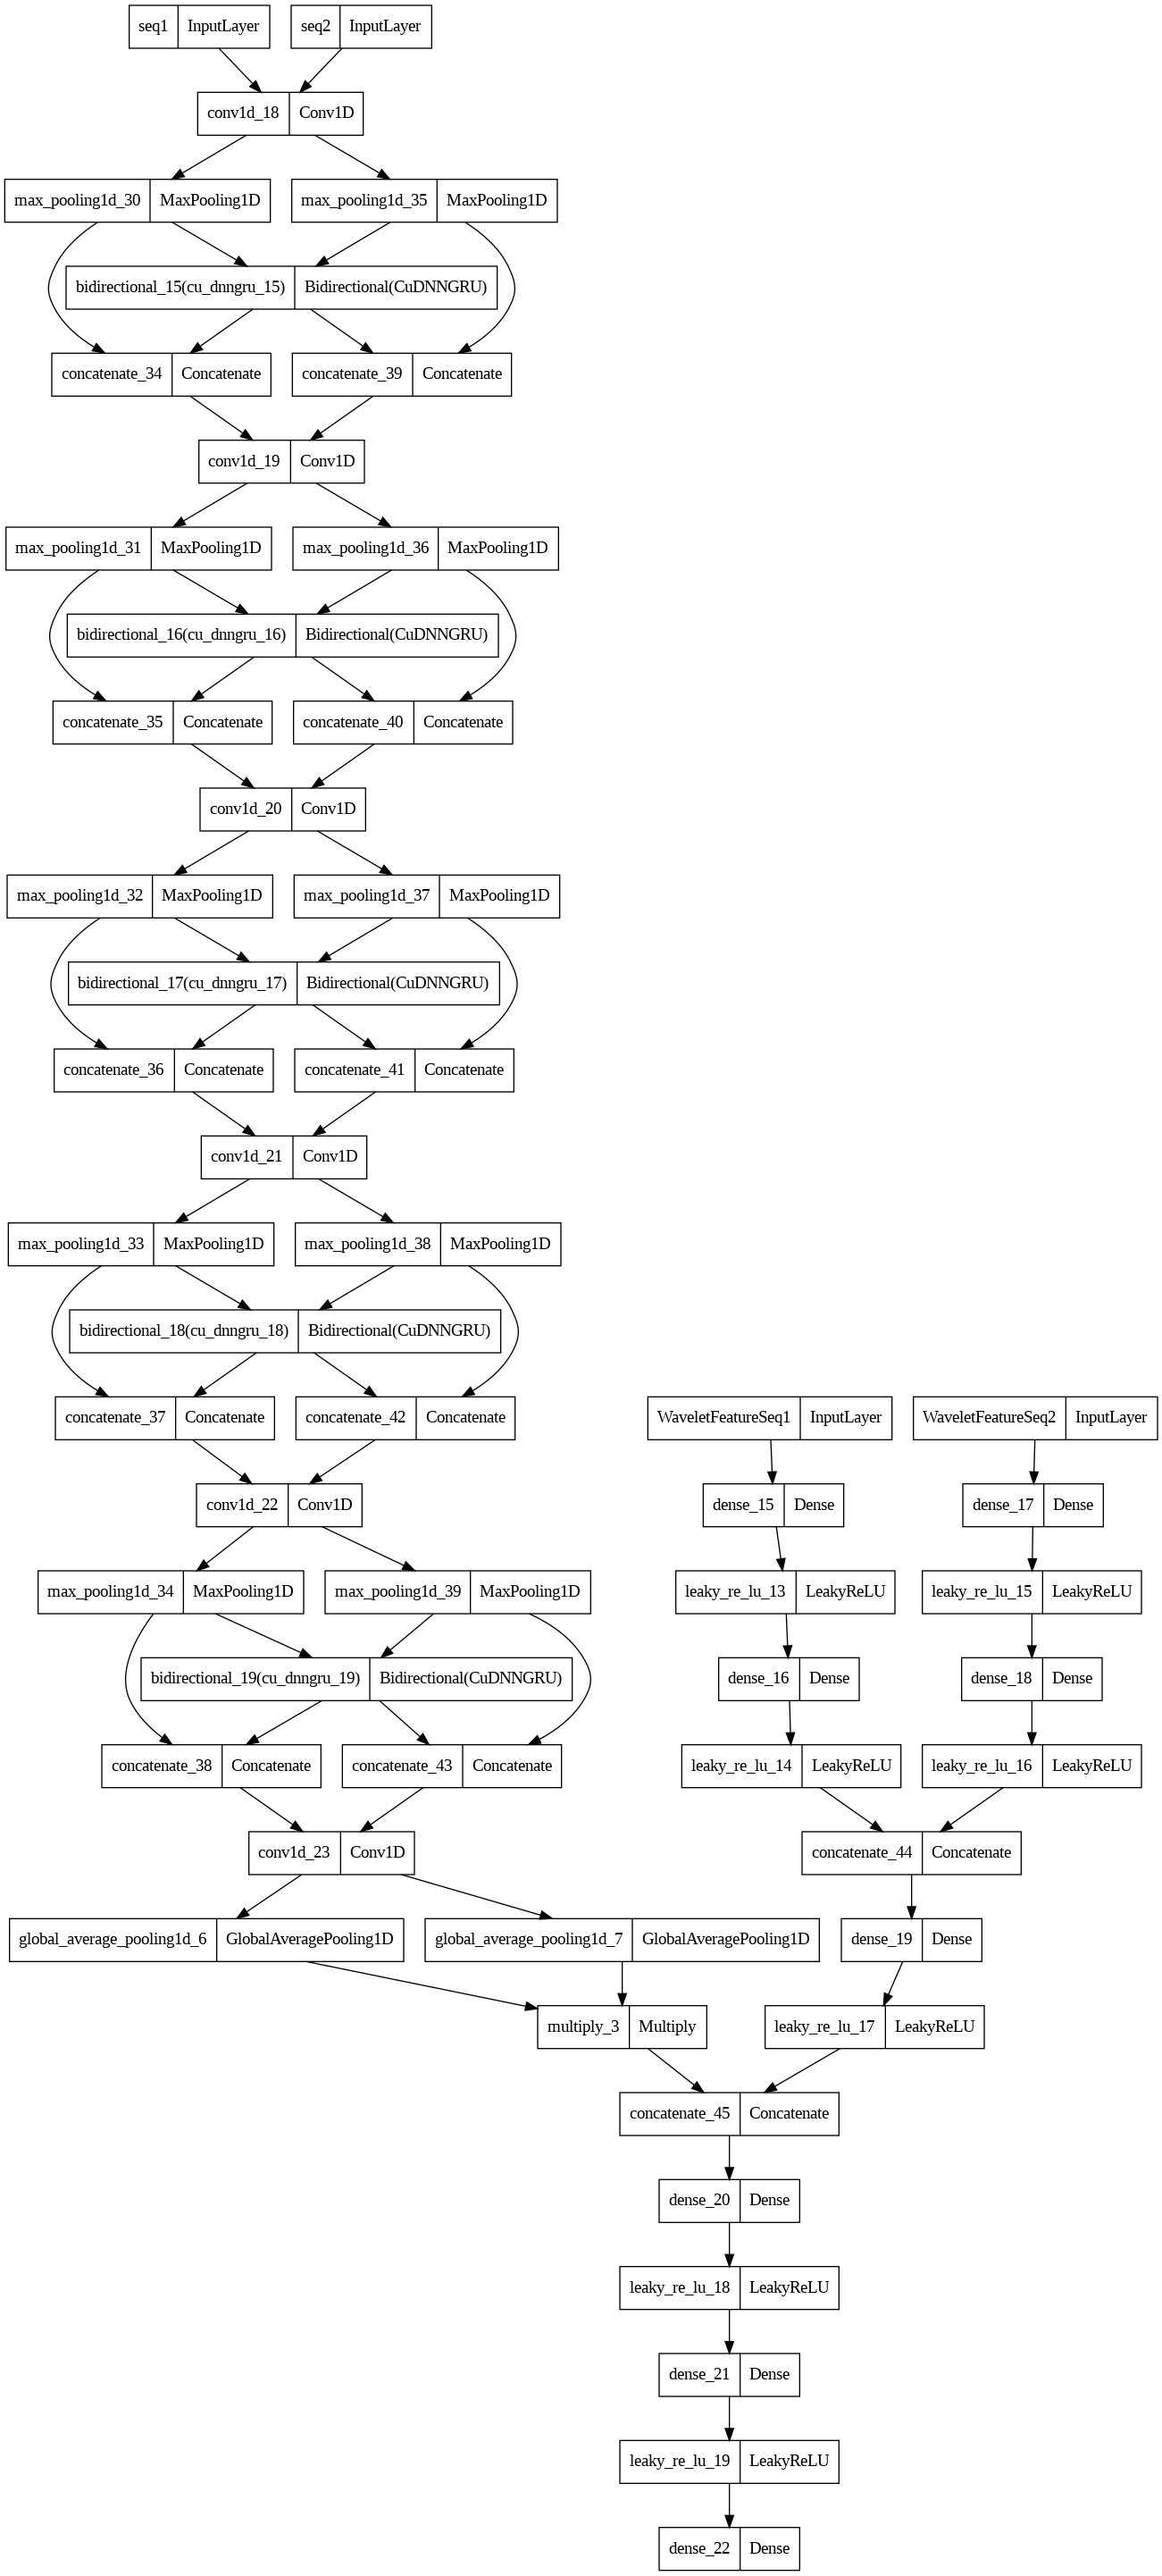

In [31]:
import graphviz
from keras.utils import plot_model
plot_model(build_model_lastLayer())

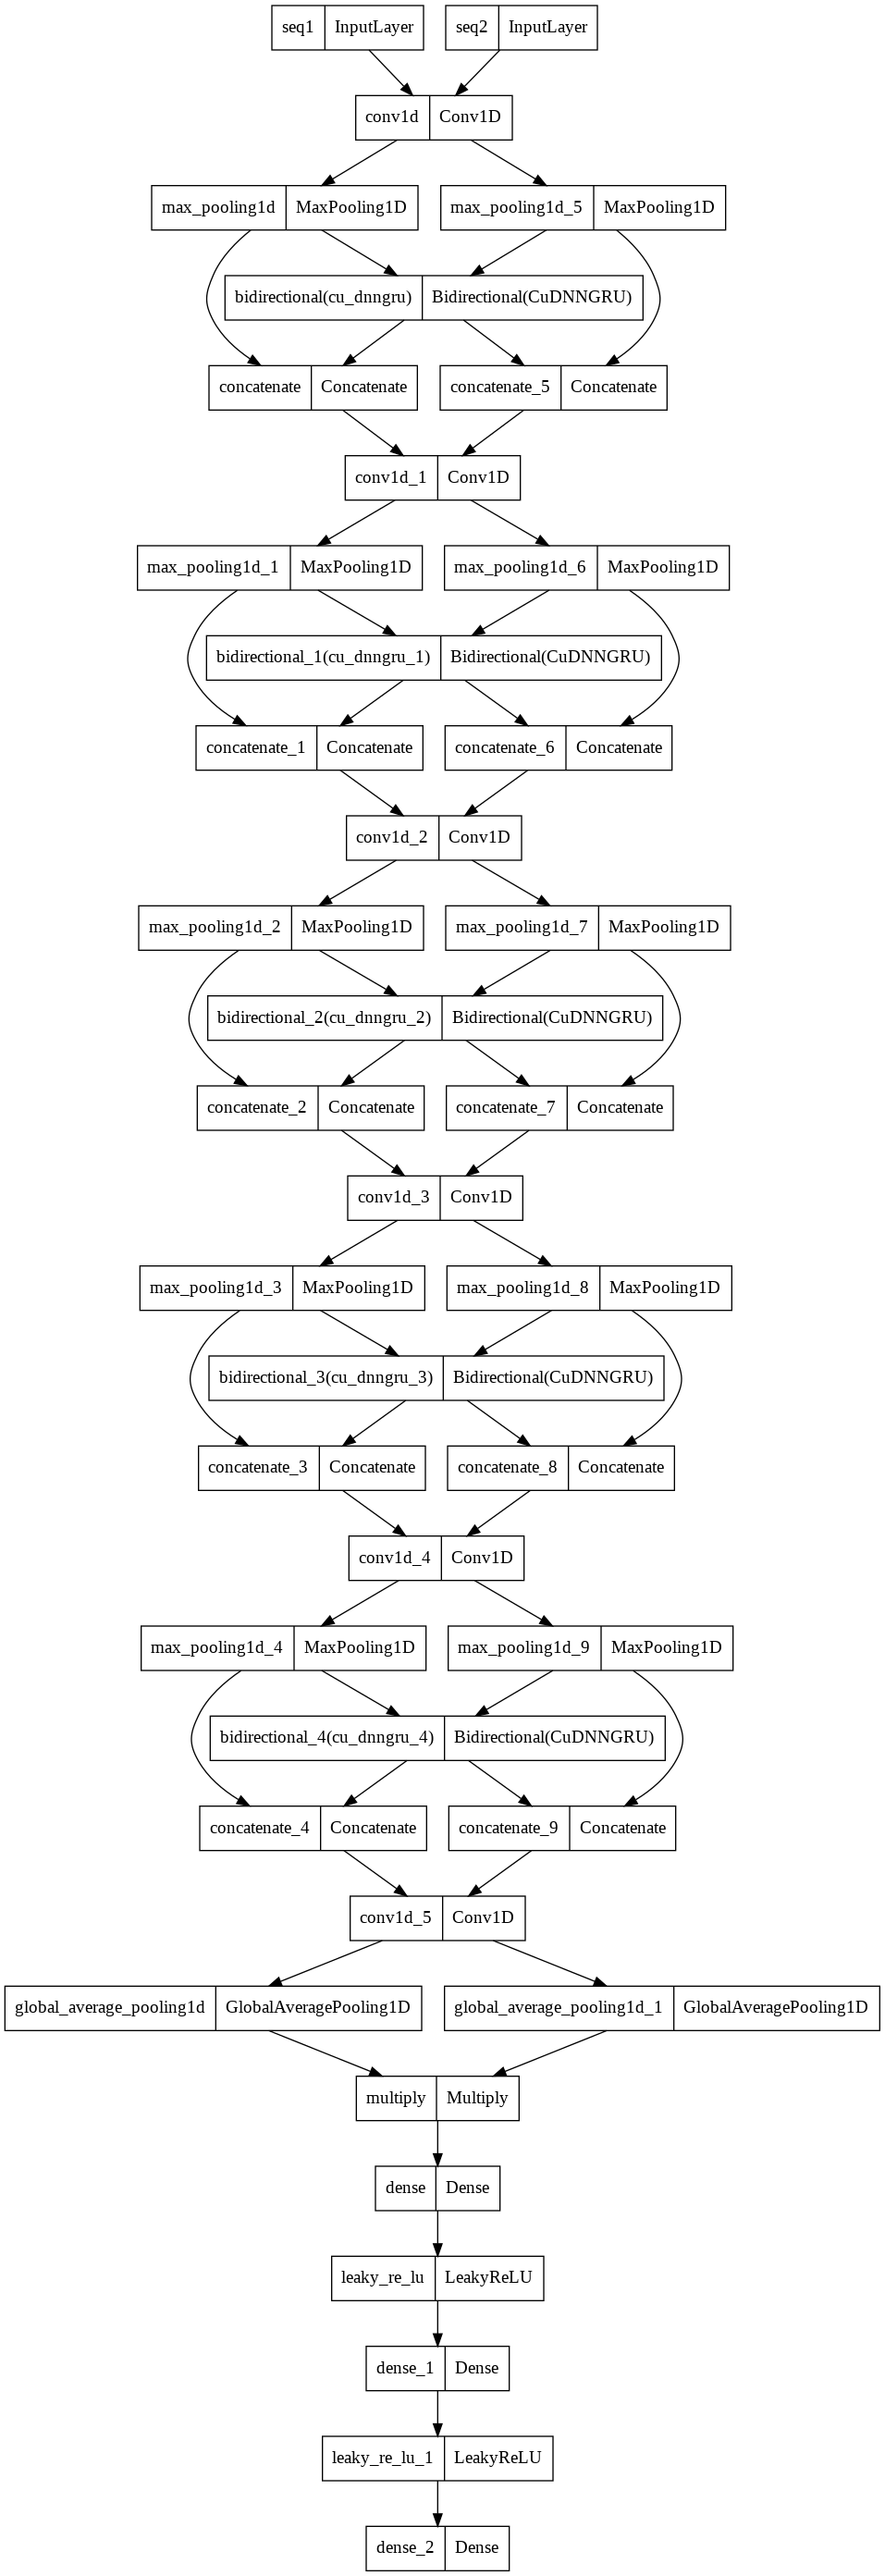

In [ ]:
import graphviz
from keras.utils import plot_model
plot_model(build_model())

In [ ]:
print(build_model().summary())
print(len(build_model().layers))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq1 (InputLayer)              [(None, 2035, 15)]   0           []                               
                                                                                                  
 seq2 (InputLayer)              [(None, 2035, 15)]   0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 2033, 25)     1150        ['seq1[0][0]',                   
                                                                  'seq2[0][0]']                   
                                                                                                  
 max_pooling1d_10 (MaxPooling1D  (None, 677, 25)     0           ['conv1d_6[0][0]']         

In [26]:

batch_size1 = 256
adam = Adam(learning_rate=0.001, amsgrad=True, epsilon=1e-6)
rms = RMSprop(learning_rate=0.001)


In [27]:
from sklearn.model_selection import KFold, ShuffleSplit
kf = KFold(n_splits=5, shuffle=True)
tries = 5
cur = 0
recalls = []
accuracy = []
total = []
total_truth = []
train_test = []
for train, test in kf.split(class_labels):
    if np.sum(class_labels[train], 0)[0] > 0.8 * len(train) or np.sum(class_labels[train], 0)[0] < 0.2 * len(train):
        continue
    train_test.append((train, test))
    cur += 1
    if cur >= tries:
        break

print (len(train_test))

5


In [ ]:
#copy below
####  new last layer
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

for train, test in train_test:
    merge_model = None
    merge_model = build_model_lastLayer()
    adam = Adam(learning_rate=0.001, amsgrad=True, epsilon=1e-6)
    rms = RMSprop(learning_rate=0.001)
    merge_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    merge_model.fit([seq_tensor[seq_index1[train]], seq_tensor[seq_index2[train]], waveletFeatureLastLayer[seq_index1[train]], waveletFeatureLastLayer[seq_index2[train]]], class_labels[train], batch_size=batch_size1, epochs=n_epochs)
    #result1 = merge_model.evaluate([seq_tensor1[test], seq_tensor2[test]], class_labels[test])
    pred = merge_model.predict([seq_tensor[seq_index1[train]], seq_tensor[seq_index2[train]], waveletFeatureLastLayer[seq_index1[train]], waveletFeatureLastLayer[seq_index2[train]]])
    for i in range(len(class_labels[test])):
        num_total += 1
        if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
            num_hit += 1
        if class_labels[test][i][0] > 0.:
            num_pos += 1.
            if pred[i][0] > pred[i][1]:
                num_true_pos += 1
            else:
                num_false_neg += 1
        else:
            if pred[i][0] > pred[i][1]:
                num_false_pos += 1
            else:
                num_true_neg += 1
    accuracy = num_hit / num_total
    prec = num_true_pos / (num_true_pos + num_false_pos)
    recall = num_true_pos / num_pos
    spec = num_true_neg / (num_true_neg + num_false_neg)
    f1 = 2. * prec * recall / (prec + recall)
    mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
    print (accuracy, prec, recall, spec, f1, mcc)

Epoch 1/100
35/35 [==============================] - 31s 358ms/step - loss: 55.8012 - accuracy: 0.5000
Epoch 2/100
35/35 [==============================] - 11s 325ms/step - loss: 13.1684 - accuracy: 0.4914
Epoch 3/100
35/35 [==============================] - 11s 319ms/step - loss: 7.0585 - accuracy: 0.4999
Epoch 4/100
35/35 [==============================] - 11s 318ms/step - loss: 4.0790 - accuracy: 0.5032
Epoch 5/100
35/35 [==============================] - 11s 316ms/step - loss: 3.7014 - accuracy: 0.5025
Epoch 6/100
35/35 [==============================] - 11s 316ms/step - loss: 1.0344 - accuracy: 0.5092
Epoch 7/100
35/35 [==============================] - 11s 316ms/step - loss: 0.7092 - accuracy: 0.5053
Epoch 8/100
35/35 [==============================] - 11s 320ms/step - loss: 0.7283 - accuracy: 0.4983
Epoch 9/100
35/35 [==============================] - 11s 322ms/step - loss: 0.7241 - accuracy: 0.5112
Epoch 10/100
35/35 [==============================] - 11s 319ms/step - loss: 0.7

In [ ]:
#copy below
####  new first layer
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

for train, test in train_test:
    merge_model = None
    merge_model = build_model()
    adam = Adam(learning_rate=0.001, amsgrad=True, epsilon=1e-6)
    rms = RMSprop(learning_rate=0.001)
    merge_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    merge_model.fit([seq_tensor[new[train]], seq_tensor[new[train]]], class_labels[train], batch_size=batch_size1, epochs=n_epochs)
    #result1 = merge_model.evaluate([seq_tensor1[test], seq_tensor2[test]], class_labels[test])
    pred = merge_model.predict([seq_tensor[new[test]], seq_tensor[new[test]]])
    for i in range(len(class_labels[test])):
        num_total += 1
        if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
            num_hit += 1
        if class_labels[test][i][0] > 0.:
            num_pos += 1.
            if pred[i][0] > pred[i][1]:
                num_true_pos += 1
            else:
                num_false_neg += 1
        else:
            if pred[i][0] > pred[i][1]:
                num_false_pos += 1
            else:
                num_true_neg += 1
    accuracy = num_hit / num_total
    prec = num_true_pos / (num_true_pos + num_false_pos)
    recall = num_true_pos / num_pos
    spec = num_true_neg / (num_true_neg + num_false_neg)
    f1 = 2. * prec * recall / (prec + recall)
    mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
    print (accuracy, prec, recall, spec, f1, mcc)

Epoch 1/100
35/35 [==============================] - 30s 345ms/step - loss: 0.6935 - accuracy: 0.5087
Epoch 2/100
35/35 [==============================] - 11s 317ms/step - loss: 0.6932 - accuracy: 0.5123
Epoch 3/100
35/35 [==============================] - 11s 320ms/step - loss: 0.6934 - accuracy: 0.5079
Epoch 4/100
35/35 [==============================] - 11s 324ms/step - loss: 0.6932 - accuracy: 0.5118
Epoch 5/100
35/35 [==============================] - 11s 326ms/step - loss: 0.6934 - accuracy: 0.5052
Epoch 6/100
35/35 [==============================] - 11s 323ms/step - loss: 0.6930 - accuracy: 0.5130
Epoch 7/100
35/35 [==============================] - 11s 322ms/step - loss: 0.6928 - accuracy: 0.5131
Epoch 8/100
35/35 [==============================] - 11s 320ms/step - loss: 0.6927 - accuracy: 0.5091
Epoch 9/100
35/35 [==============================] - 11s 319ms/step - loss: 0.6933 - accuracy: 0.5060
Epoch 10/100
35/35 [==============================] - 11s 322ms/step - loss: 0.692

In [ ]:
#copy below
# old
num_hit = 0.
num_total = 0.
num_pos = 0.
num_true_pos = 0.
num_false_pos = 0.
num_true_neg = 0.
num_false_neg = 0.

for train, test in train_test:
    merge_model = None
    merge_model = build_model_org()
    adam = Adam(learning_rate=0.001, amsgrad=True, epsilon=1e-6)
    rms = RMSprop(learning_rate=0.001)
    merge_model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    merge_model.fit([seq_tensor[seq_index1[train]], seq_tensor[seq_index2[train]]], class_labels[train], batch_size=batch_size1, epochs=n_epochs)
    #result1 = merge_model.evaluate([seq_tensor1[test], seq_tensor2[test]], class_labels[test])
    pred = merge_model.predict([seq_tensor[seq_index1[test]], seq_tensor[seq_index2[test]]])
    for i in range(len(class_labels[test])):
        num_total += 1
        if np.argmax(class_labels[test][i]) == np.argmax(pred[i]):
            num_hit += 1
        if class_labels[test][i][0] > 0.:
            num_pos += 1.
            if pred[i][0] > pred[i][1]:
                num_true_pos += 1
            else:
                num_false_neg += 1
        else:
            if pred[i][0] > pred[i][1]:
                num_false_pos += 1
            else:
                num_true_neg += 1
    accuracy = num_hit / num_total
    prec = num_true_pos / (num_true_pos + num_false_pos)
    recall = num_true_pos / num_pos
    spec = num_true_neg / (num_true_neg + num_false_neg)
    f1 = 2. * prec * recall / (prec + recall)
    mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
    print (accuracy, prec, recall, spec, f1, mcc)

Epoch 1/100
35/35 [==============================] - 31s 368ms/step - loss: 0.6953 - accuracy: 0.4982
Epoch 2/100
35/35 [==============================] - 11s 316ms/step - loss: 0.6931 - accuracy: 0.5132
Epoch 3/100
35/35 [==============================] - 11s 319ms/step - loss: 0.6933 - accuracy: 0.5047
Epoch 4/100
35/35 [==============================] - 11s 321ms/step - loss: 0.6930 - accuracy: 0.5088
Epoch 5/100
35/35 [==============================] - 11s 320ms/step - loss: 0.6929 - accuracy: 0.5119
Epoch 6/100
35/35 [==============================] - 11s 317ms/step - loss: 0.6929 - accuracy: 0.5100
Epoch 7/100
35/35 [==============================] - 11s 314ms/step - loss: 0.6931 - accuracy: 0.5187
Epoch 8/100
35/35 [==============================] - 11s 315ms/step - loss: 0.6933 - accuracy: 0.5055
Epoch 9/100
35/35 [==============================] - 11s 318ms/step - loss: 0.6931 - accuracy: 0.5102
Epoch 10/100
35/35 [==============================] - 11s 318ms/step - loss: 0.693

In [ ]:
accuracy = num_hit / num_total
prec = num_true_pos / (num_true_pos + num_false_pos)
recall = num_true_pos / num_pos
spec = num_true_neg / (num_true_neg + num_false_neg)
f1 = 2. * prec * recall / (prec + recall)
mcc = (num_true_pos * num_true_neg - num_false_pos * num_false_neg) / ((num_true_pos + num_true_neg) * (num_true_pos + num_false_neg) * (num_false_pos + num_true_neg) * (num_false_pos + num_false_neg)) ** 0.5
print (accuracy, prec, recall, f1)

NameError: ignored